In [1]:
import numpy as np
import scipy as sp
import scipy.stats as st
import matplotlib.pyplot as plt
####import seaborn
%matplotlib inline

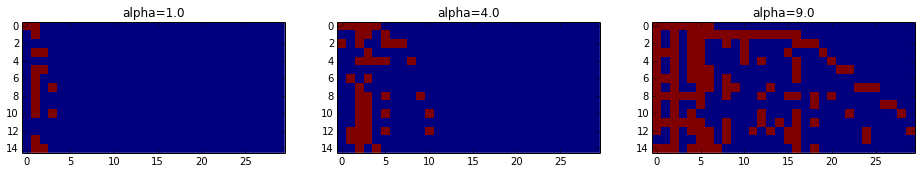

In [17]:

def get_ibp(alpha):
    z = np.zeros([15,30])
    new = 0
    for j in range(15):
        ### old phase
        to_beru = np.sum(z,0)
        for k in range(new):
            z[j,k]=np.random.binomial(1,to_beru[k]*1.0/(j+1))
        ### new phase
        new_alpha = alpha*1.0/(j+1)
        new_to_add = np.random.poisson(new_alpha)
        z[j,new:new+new_to_add]=1
        #### old phase
        ##for k in range(len(new_to_add)):        
        ### update new
        new = new+new_to_add
    return z

para =[1.0,4.0,9.0]
plt.figure(figsize=(16,5))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.title("alpha="+str(para[i]))
    hoge = get_ibp(para[i])
    plt.imshow(hoge,interpolation='none' )
plt.savefig("IBP.png")
plt.show()

(4, 1, 25)


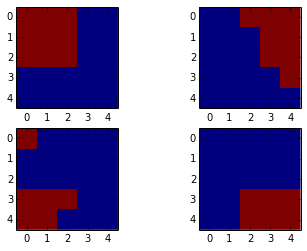

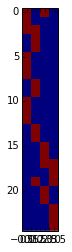

In [57]:
#### generate sample
n = 20
true_z = []
for i in range(4): 
    true_z.append(np.zeros(25).reshape(5,5))
    if i==0:
        true_z[i][0:3,0:3]=1
    elif i==1:
        true_z[i][0:3,3:5]=1
        true_z[i][0,2]=1
        true_z[i][3,4]=1
    elif i==2:
        true_z[i][3:5,0:3]=1
        true_z[i][0,0]=1
        true_z[i][4,2]=0
    elif i==3:
        true_z[i][3:5,2:5]=1

    
true_z_flat2 = np.array([i.reshape(1,25) for i in true_z])
print true_z_flat2.shape
true_z_flat2 = np.transpose(true_z_flat2.reshape(4,25))

for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(true_z[i],interpolation='none')
plt.show()

plt.imshow(true_z_flat2,interpolation='none')
plt.show()


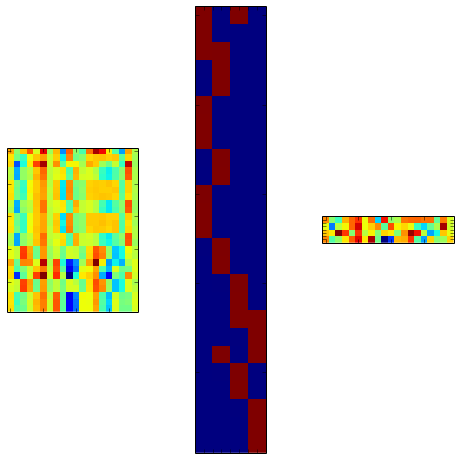

In [92]:
xxx = np.random.normal(0,2.0,4*n).reshape(4,n)
yyy = np.dot(true_z_flat2,xxx) + np.random.normal(0,0.1,25*n).reshape((25,n))

plt.figure(figsize=(8,8))
plt.subplot(1,3,3)
plt.tick_params(labelbottom='off')
plt.tick_params(labelleft='off')
plt.imshow(xxx,interpolation='none')
plt.subplot(1,3,1)
plt.tick_params(labelbottom='off')
plt.tick_params(labelleft='off')
plt.imshow(yyy,interpolation='none')
plt.subplot(1,3,2)
plt.tick_params(labelbottom='off')
plt.tick_params(labelleft='off')
plt.imshow(true_z_flat2,interpolation='none')
plt.savefig("situation.png")
plt.show()

In [139]:
def factorial(n):
    if n==0:
        return 1
    elif n>=1:
        return n*factorial(n-1)


In [41]:
def poisson_pdf(_lambda,x):
    return np.power(_lambda,x)*np.exp(-_lambda)*1.0/factorial(x)

def gibbs_for_z(i,k,z,Y,X,sigma_y,alpha,N):
    ###### first calculate n_i_k
    pesdo_n_i_k = np.sum(z,0)[k]
    if z[i,k]==1:
        n_i_k = pesdo_n_i_k -1
    else:
        n_i_k = pesdo_n_i_k
    
    hoge1 = pesdo_n_i_k*1.0/N
    hoge0 = 1-hoge1
    ##### calculate likelihood
    z1 = np.copy(z[i,:].reshape(z.shape[1]))
    z1[k]=1
    mean1 = np.dot(z1,X)
    z2 = np.copy(z[i,:].reshape(z.shape[1]))
    z2[k]=0
    mean2 = np.dot(z2,X)
    sigma = np.identity(20)*sigma_y
    hoge3 = st.multivariate_normal.pdf(Y[i],mean1,sigma)*hoge1
    hoge4 = st.multivariate_normal.pdf(Y[i],mean2,sigma)*hoge0
    return np.random.binomial(1,hoge3*1.0/(hoge3+hoge4))

def gibbs_for_m(i,z,Y,X,sigma_y,sigma_x,alpha,N):
    sigma = np.identity(20)*sigma_y
    new_x = np.random.normal(0,2.0,100).reshape((5,20))
    candidate_list = []
    for j in range(4):
        p0 = poisson_pdf(alpha*1.0/N,j)
        hoge = st.multivariate_normal.pdf(Y[i],np.dot(z[i,:],X)+np.sum(new_x[0:j],0),sigma_y)
        candidate_list.append(p0*hoge)
    candidate_list = candidate_list/np.sum(np.array(candidate_list))
    multi_list = np.random.multinomial(1,candidate_list)
    for kkk in range(5):
        if multi_list[kkk]==1:
            newx = np.concatenate([X,new_x[0:kkk]])
            newz = np.concatenate([z,np.zeros(Y.shape[0]*4).reshape((Y.shape[0],4))[:,0:kkk]],1)
            if kkk!=0:
                newz[i,z.shape[1]:z.shape[1]+kkk] = 1
            return [newx,newz]

def gibbs_for_x(z,Y,X,sigma_y,sigma_x,alpha,N):
    newx = []
    inverse_vx = np.dot(np.transpose(z),z)+sigma_y*1.0/sigma_x*np.identity(z.shape[1])
    vx = np.linalg.inv(inverse_vx)
    vxy = sigma_y*vx
    for i in range(Y.shape[1]):
        yi = Y[:,i]
        mean = np.dot(vx,np.dot(np.transpose(z),yi))
        variance = vxy
        newx.append(np.random.multivariate_normal(mean,vxy))
    return np.transpose(np.array(newx))


In [137]:
x = np.random.normal(0,2.0,1*n).reshape(1,n)
true_z_flat = np.random.binomial(1,0.1,25).reshape((25,1))

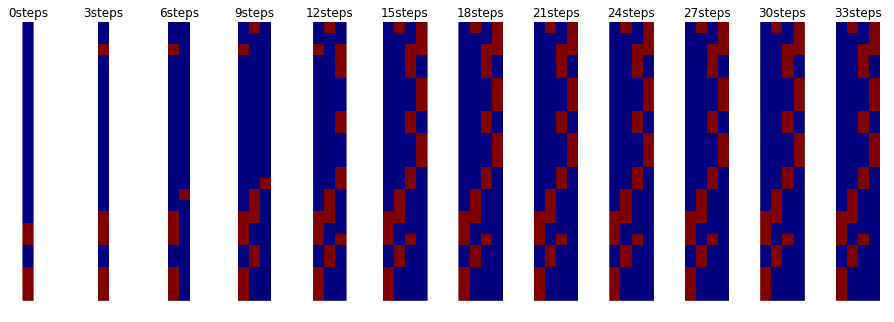

In [138]:
alpha = 1
plt.figure(figsize=(16,5))
for sss in range(36):    
    i,j = true_z_flat.shape
    pesdo_z = np.zeros(i*j).reshape((i,j))
    #####
    pesdo_z = np.zeros(i*j).reshape((i,j))
    for kk1 in range(i):
        for kk2 in range(j):
            pesdo_z[kk1,kk2] = gibbs_for_z(kk1,kk2,true_z_flat,yyy,x,0.3,alpha,n)
    true_z_flat = pesdo_z
    #######
    for j in range(25):
        x,true_z_flat = gibbs_for_m(j,true_z_flat,yyy,x,0.3,2.0,alpha,n)
    if sss%3==0:
        plt.subplot(1,12,sss/3+1)
        plt.imshow(true_z_flat,interpolation='none')
        plt.title(str(sss)+"steps")
        plt.axis('off')
    ############
    x= gibbs_for_x(true_z_flat,yyy,x,0.3,2.0,alpha,n)
##plt.savefig("ibp.png")
plt.show()

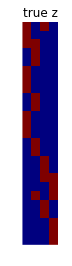

In [146]:
plt.imshow(true_z_flat2,interpolation='none')
plt.title("true z")
plt.axis('off')
###plt.savefig("true_z.png")
plt.show()